<a href="https://colab.research.google.com/github/onemira/kickstarter_data_analysis/blob/main/AI_09_%EA%B0%95%EB%AF%B8%EB%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*SEC2 PROJECT/ Kickstarter Successful Project Prediction*



---




##💰 **Kickstarter?** 


> **Kickstarter** is *the crowdfunding platform* that helps bring creative projects to life. A home for film, music, art, theater, games, comics, design, photography, and more.



###**Goal** 🥅

How to raise funding successfully on Kickstarter?

##**Data Overview**🔍

In [ ]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from category_encoders import (
    OneHotEncoder, TargetEncoder, OrdinalEncoder
)

#Importing the auxiliar and preprocessing librarys 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, cross_val_score,  KFold, cross_validate
)
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score

#Models
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.compose import ColumnTransformer


In [ ]:
#@title
#pip install category_encoders

In [ ]:
#@title
link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTmFnQByfpIlT__Xct4-8dtkBV0n7WNAL5btanJJOKlEh3bJ7X2POEeNGAuNu_ocDwzgnJjMlQDgBCK/pub?gid=2022291456&single=true&output=csv'
df = pd.read_csv(link)


In [ ]:
print(df.shape)
df.tail(3)

(45957, 17)


,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
45954,2147367534,ELIZABETH REX,http://www.kickstarter.com/projects/elizabethr...,Music,Rock,"Los Angeles, CA",successful,10000.0,10000.0,1.000000,58,"Mon, 16 Jan 2012 05:00:00 -0000",4,"$10,$25,$100,$500",2,0,27.32
45955,2147369705,Dragon Keepers IV Book Project,http://www.kickstarter.com/projects/brucegoldw...,Publishing,Fiction,"Vero Beach, FL",failed,2999.0,257.0,0.085695,11,"Sat, 19 May 2012 19:44:47 -0000",7,"$15,$16,$19,$29,$29,$39,$75",17,0,30.00
45956,2147460119,Moments of Insight,http://www.kickstarter.com/projects/1743305220...,Art,Conceptual Art,"Bozeman, MT",successful,18000.0,18758.0,1.042111,53,"Thu, 04 Aug 2011 04:30:00 -0000",10,"$25,$25,$50,$100,$125,$250,$500,$1,250,$2,500,...",20,4,40.38


**Exploratory Data Analysis** 🔍

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45957 entries, 0 to 45956
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   project id         45957 non-null  int64  
 1   name               45957 non-null  object 
 2   url                45957 non-null  object 
 3   category           45957 non-null  object 
 4   subcategory        45957 non-null  object 
 5   location           44635 non-null  object 
 6   status             45957 non-null  object 
 7   goal               45957 non-null  float64
 8   pledged            45945 non-null  float64
 9   funded percentage  45957 non-null  float64
 10  backers            45957 non-null  int64  
 11  funded date        45957 non-null  object 
 12  levels             45957 non-null  int64  
 13  reward levels      45898 non-null  object 
 14  updates            45957 non-null  int64  
 15  comments           45957 non-null  int64  
 16  duration           459

In [ ]:
df.describe()

,project id,goal,pledged,funded percentage,backers,levels,updates,comments,duration
count,4.595700e+04,4.595700e+04,4.594500e+04,45957.000000,45957.000000,45957.000000,45957.00000,45957.000000,45957.000000
mean,1.080800e+09,1.194271e+04,4.980750e+03,1.850129,69.973192,8.004939,4.08508,8.379529,39.995547
std,6.218057e+08,1.887583e+05,5.674162e+04,88.492706,688.628479,4.233907,6.43922,174.015737,17.414458
min,3.940900e+04,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,5.438962e+08,1.800000e+03,1.960000e+02,0.044000,5.000000,5.000000,0.00000,0.000000,30.000000
50%,1.078345e+09,4.000000e+03,1.310000e+03,1.000000,23.000000,7.000000,2.00000,0.000000,32.000000
75%,1.621596e+09,9.862000e+03,4.165000e+03,1.115640,59.000000,10.000000,6.00000,3.000000,48.390000
max,2.147460e+09,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.00000,19311.000000,91.960000


###Data Cleaning 🧹

In [ ]:
#Missing values identified
[(x, df[x].isnull().sum()) for x in df.columns if df[x].isnull().any()]
df.isna().sum().sort_values()

#Duplicates deleted
df.duplicated().value_counts()
df.drop_duplicates()

#drop unnecessary and too relevant columns
df.drop(columns= ['project id', 'name', 'url', 'pledged', 'funded percentage', 'reward levels', 'updates', 'comments'], axis = 1,  inplace = True)

#Outliners identified
df.describe(exclude='number').T.sort_values(by='unique')

#Outliners deleted
df = df[(df['goal'] >= np.percentile(df['goal'], 10)) & (df['goal'] <= np.percentile(df['goal'], 90))] 
df = df[(df['duration'] >= np.percentile(df['duration'], 10)) & (df['duration'] <= np.percentile(df['duration'], 90))] 
df = df[(df['levels'] >= np.percentile(df['levels'], 10)) & (df['levels'] <= np.percentile(df['levels'], 90))] 
df = df.groupby("location").filter(lambda x: len(x) > 55)

##**Feature Engineering**  ⚒

In [ ]:
#target dataset: get rid of outliers in target  - "successful/failed" value only
target = 'status'
invalid_status = df[target].isin(['live', 'canceled', 'suspended'])
df = df[~invalid_status]

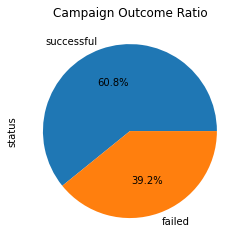

In [ ]:
x = df[target].value_counts()

x.plot(kind='pie', figsize=(4, 4), autopct='%1.1f%%',labels=['successful','failed'], fontsize=10, title='Campaign Outcome Ratio')

In [ ]:
def wrangle(df):

    #goal: to_int
    df['goal'] =df['goal'].astype(int)

   #adjust high cardinality target 
    df['location'] = df['location'].str.split(',').str[0]

   #replace '&amp;' with '&'
    df['category'] = df['category'].str.replace('&amp;', '&')
    df['subcategory'] = df['subcategory'].str.replace('&amp;', '&')

    #format 변경: to_datetime
    df['funded date'] = pd.to_datetime(df['funded date'], infer_datetime_format=True)

    #'break down funded_date' column
   # df['funded_year']  =df['funded date'].dt.year
    df['funded_month']  =df['funded date'].dt.month
   #df['funded_day']  = df['funded date'].dt.day
    df['funded_hour']  =df['funded date'].dt.hour
    df['funded_day_name']  = df['funded date'].dt.day_name() 
    df = df.drop('funded date', axis = 1, inplace = True)
    return df

wrangle(df)


##**Data Visualization** 📊

In [ ]:
#@title
success = df[df['status'] == 'successful']['category'].value_counts().values
failure = df[df['status'] == 'failed']['category'].value_counts().values

####Feature Corelation Heatmap

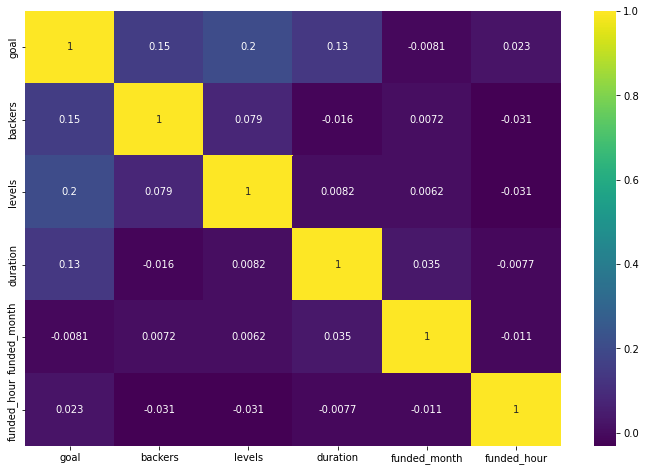

In [ ]:
#@title
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

 

#### Goal Distribution

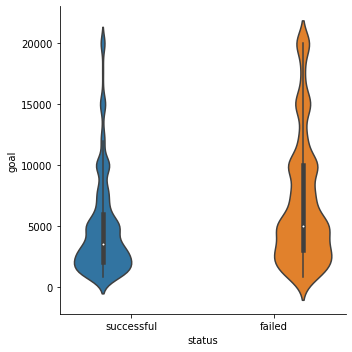

In [ ]:
sns.catplot(x='status',y='goal', kind='violin', data=df, hue="status")

plt.show()

### Duration Distribution 

In [ ]:
#@title
successful = df.loc[df.status=='successful']
failed = df.loc[df.status=='failed']

print('Mean duration of successful campaigns(days)',successful['duration'].mean())
print('Mean duration of failed campaigns (days)', failed['duration'].mean())


Mean duration of successful campaigns(days) 37.5631698380807
Mean duration of failed campaigns (days) 39.90846210313816


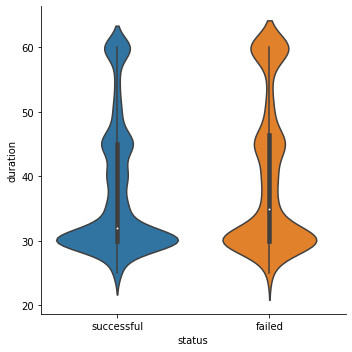

In [ ]:
sns.catplot(x='status',y='duration', kind='violin', data=df)
plt.show()

###Location Distribution

In [ ]:
#@title
location = df['location'].unique()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=location,
    y=success,
    name='successful',
    marker_color='lightblue'
))
fig.add_trace(go.Bar(
    x=location,
    y=failure,
    name='failed',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(width=800, barmode='group', xaxis_tickangle=-45, title_text='Most Successful Location for Project Funding')
fig.show()

###Reward Level Distribution

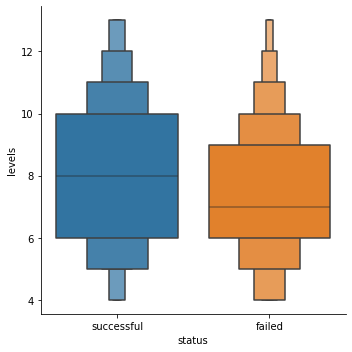

In [ ]:
#@title
sns.catplot(x='status',y='levels', kind='boxen', data=df)
plt.show()

### Category Distribution

In [ ]:
#@title
import plotly.graph_objects as go

cat = df['category'].unique()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=cat,
    y=success,
    name='successful',
    marker_color='lightblue'
))
fig.add_trace(go.Bar(
    x=cat,
    y=failure,
    name='failed',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(width=800, barmode='group', xaxis_tickangle=-45, title_text='Most Successful Category for Project Funding')
fig.show()

In [ ]:
#@title
sub_cat = df['subcategory'].unique()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=sub_cat,
    y=success,
    name='successful',
    marker_color='lightblue'
))
fig.add_trace(go.Bar(
    x=sub_cat,
    y=failure,
    name='failed',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(width=800, barmode='group', xaxis_tickangle=-45, title_text='Most Successful SubCategory for Project Funding')
fig.show()

### Month/ Day/ Hour Distribution

In [ ]:
#@title
#ideal month
month = df['funded_month'].unique()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=month,
    y=success,
    name='successful',
    marker_color='lightblue'
))
fig.add_trace(go.Bar(
    x=month,
    y=failure,
    name='failed',
    marker_color='lightsalmon'
))
fig.update_layout(width=800, barmode='group',  title_text='The Ideal Month to Launch a Campaign')
fig.show()

#ideal name of day
day = df['funded_day_name'].unique()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=day,
    y=success,
    name='successful',
    marker_color='lightblue'
))
fig.add_trace(go.Bar(
    x=day,
    y=failure,
    name='failed',
    marker_color='lightsalmon'
))
fig.update_layout(width=800, barmode='group', xaxis_tickangle=-45, title_text='The Ideal Day to Launch a Campaign')
fig.show()


#ideal hour
year = df['funded_hour'].unique()
fig = go.Figure()
fig.add_trace(go.Bar(
    x=year,
    y=success,
    name='successful',
    marker_color='lightblue'
))
fig.add_trace(go.Bar(
    x=year,
    y=failure,
    name='failed',
    marker_color='lightsalmon'
))
fig.update_layout(width=800, barmode='group', xaxis_tickangle=-45, title_text='The Ideal Hour to Launch a Campaign')
fig.show()


##Machine Learning Modeling 🤖 

###**Target Column: status**

*   "successful" states as outcome = 0
*   "failed" state as outcome = 1



In [ ]:
#@title
  # target value: successed => 0 = No, 1 = Yes
  df[target] = df[target].map({'successful': 0, 'failed': 1})

In [ ]:
#@title
# 데이터셋 분리
X = df.drop(columns= [target, 'subcategory', 'backers'])
y = df[target]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.3
    , random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3
    , random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (6815, 8)
y_train shape (6815,)
X_val shape (2922, 8)
y_val shape (2922,)
X_test shape (4173, 8)
y_test shape (4173,)


In [ ]:
#@title
clfs = []
seed = 3

numeric_features = ['goal', 'levels', 'duration', 'funded_month', 'funded_hour']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ['category', 'location','funded_day_name']
categorical_transformer = OrdinalEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
clfs.append(("LogReg", 
             Pipeline(steps=[
                      ("preprocessor", preprocessor),
                       ("classifier", LogisticRegression(n_jobs=-1, random_state=42))])))

clfs.append(("XGBClassifier",
             Pipeline(steps=[
                              ("preprocessor", preprocessor),
                       ("classifier", XGBClassifier(n_jobs=-1, random_state=42))]))) 

clfs.append(("KNN", 
             Pipeline(steps=[
                                    ("preprocessor", preprocessor),
                       ("classifier", KNeighborsClassifier(n_jobs=-1))]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline(steps=[
                             ("preprocessor", preprocessor),
                       ("classifier", DecisionTreeClassifier(random_state=42))]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline(steps=[
                                 ("preprocessor", preprocessor),
                             ("imputer", SimpleImputer()),
                       ("classifier", RandomForestClassifier(n_jobs=-1, random_state=42, oob_score=True))]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline(steps=[
                           ("Encoder", TargetEncoder()),
                       ("classifier", GradientBoostingClassifier(random_state=42))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline(steps=[
                                ("preprocessor", preprocessor),
                       ("classifier", RidgeClassifier(random_state=42))])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([
                         ("preprocessor", preprocessor),
                       ("classifier", BaggingClassifier(n_jobs=-1, random_state=42))])))

clfs.append(("ExtraTreesClassifier",
             Pipeline(steps=[
                                  ("preprocessor", preprocessor),
                       ("classifier", ExtraTreesClassifier(n_jobs=-1, random_state=42))])))



##평가지표

###ROC AUC

In [370]:
#@title
#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'roc_auc'
n_folds = 5

results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds)
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv= n_folds, scoring=scoring,
                                 n_jobs=-1)   
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    names.append(name)
    results.append(cv_results)    
    print(msg)


LogReg: 0.670482 (+/- 0.009107)
XGBClassifier: 0.704962 (+/- 0.014976)
KNN: 0.610597 (+/- 0.011828)
DecisionTreeClassifier: 0.551015 (+/- 0.013907)
RandomForestClassifier: 0.682386 (+/- 0.011013)
GradientBoostingClassifier: 0.714733 (+/- 0.014119)
RidgeClassifier: 0.670797 (+/- 0.009190)
BaggingRidgeClassifier: 0.637781 (+/- 0.022660)
ExtraTreesClassifier: 0.667510 (+/- 0.014839)


###Confusion Matrix

In [ ]:
from sklearn.pipeline import make_pipeline

processor = OrdinalEncoder()
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

gb_model = GradientBoostingClassifier(n_estimators=200
                  , random_state=2
                  , max_depth=7
                  , learning_rate=0.2
                  )

gb_model.fit(X_train_processed, y_train)


GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=200,
                           random_state=2)

In [ ]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
X_val_processed = processor.transform(X_val)
class_index = 1
y_pred_proba = gb_model.predict_proba(X_test_processed)[:, class_index]
print(roc_auc_score(y_test, y_pred_proba)) 

0.6775934593541126


In [374]:
#@title
# Confusion matrix
from sklearn.metrics import classification_report
y_val_pred = gb_model.predict(X_val_processed)

print('검증 정확도', gb_model.score(X_val_processed, y_val))
print(classification_report(y_val, y_val_pred))

검증 정확도 0.6409993155373033
              precision    recall  f1-score   support

           0       0.68      0.76      0.72      1761
           1       0.56      0.46      0.50      1161

    accuracy                           0.64      2922
   macro avg       0.62      0.61      0.61      2922
weighted avg       0.63      0.64      0.63      2922



### Feature Importances

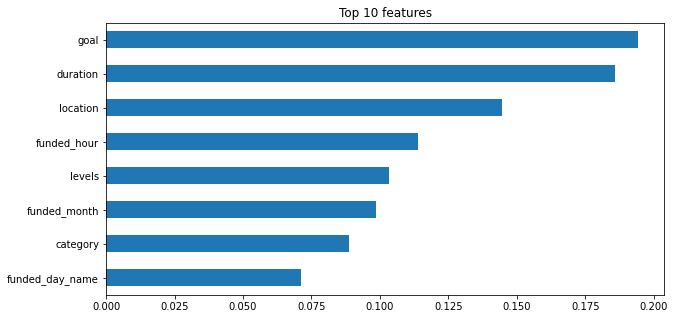

In [376]:
#@title
%matplotlib inline
import matplotlib.pyplot as plt

importances = pd.Series(gb_model.feature_importances_, X_train.columns)

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

###Predict a sample with SHAP

In [ ]:
#@title
pip install shap

In [ ]:
#@title
def explain(row_number):
    positive_class = 'Fully Paid'
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    # 예측하고 예측확률을 얻습니다 
    pred = gb_model.predict(row_processed)[0]
    pred_proba = gb_model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # 예측결과와 확률값을 얻습니다
    print(f'이 프로젝트에 대한 예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')
    
    # SHAP를 추가합니다
    shap_values = explainer.shap_values(row_processed)

    # Fully Paid에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )

In [ ]:
explain(9)

이 프로젝트에 대한 예측결과는 0 으로, 확률은 99% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. location : New York
2. category : Music
3. funded_hour : 22


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. funded_month : 10
2. levels : 7
3. duration : 30.0


In [ ]:
explain(50)

이 프로젝트에 대한 예측결과는 0 으로, 확률은 98% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. location : Brooklyn
2. funded_month : 2
3. levels : 8


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. duration : 30.0
2. category : Art
3. goal : 5000


In [ ]:
explain(200)

이 프로젝트에 대한 예측결과는 0 으로, 확률은 97% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. category : Theater
2. goal : 2500
3. duration : 31.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. levels : 4
2. funded_hour : 21
3. funded_day_name : Friday


##Conclusion 📝

###Sucessful Campaign Model



*   Goal:  ~USD 5,000
*   Posting Duration: 37 days ~
*   Location: NYC, LA, Brooklyn, Chicago, SF, Portland, SEA, BOS
*   Funded Hour: PST 9pm - 12pm 
*   Reward Level: 8
*  Funding Month: April, December



